# Generate the figures

## Imports

In [11]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import pickle
import seaborn as sns
import os
import pandas as pd
import muon as mu
import scanpy as sc
import mofax
import anndata as ad

## Load the data

In [12]:
# Define the data and figure folder.
data_folder = "/users/csb/huizing/Documents/PhD/Code/mowgli_reproducibility/data/"

In [13]:
mdata = mu.read_h5mu(data_folder + "TEA/tea_preprocessed.h5mu.gz")

In [14]:
mofa_model = mofax.mofa_model(data_folder + "TEA/tea_mofa_15.hdf5")
mdata.obsm["X_mofa"] = mofa_model.get_factors()
mdata.uns = {}


## Plot the embedding

In [15]:
joint_embedding = ad.AnnData(mdata.obsm["X_mofa"], obs=mdata.obs)
joint_embedding.obs[mdata["adt"].var_names] = mdata["adt"].X

In [16]:
sc.pp.neighbors(joint_embedding, n_neighbors=25)
sc.tl.umap(joint_embedding)

In [17]:
sc.tl.leiden(joint_embedding, resolution=.2, key_added="leiden")
sc.tl.leiden(joint_embedding, resolution=3, key_added="leiden_precise")

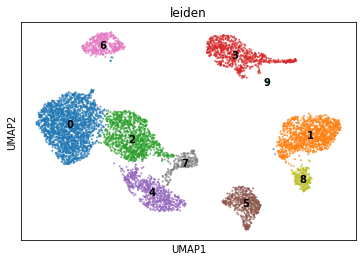

In [18]:
sc.pl.umap(joint_embedding, color="leiden", alpha=.7, legend_loc="on data", save="tea_leiden_mofa.pdf")

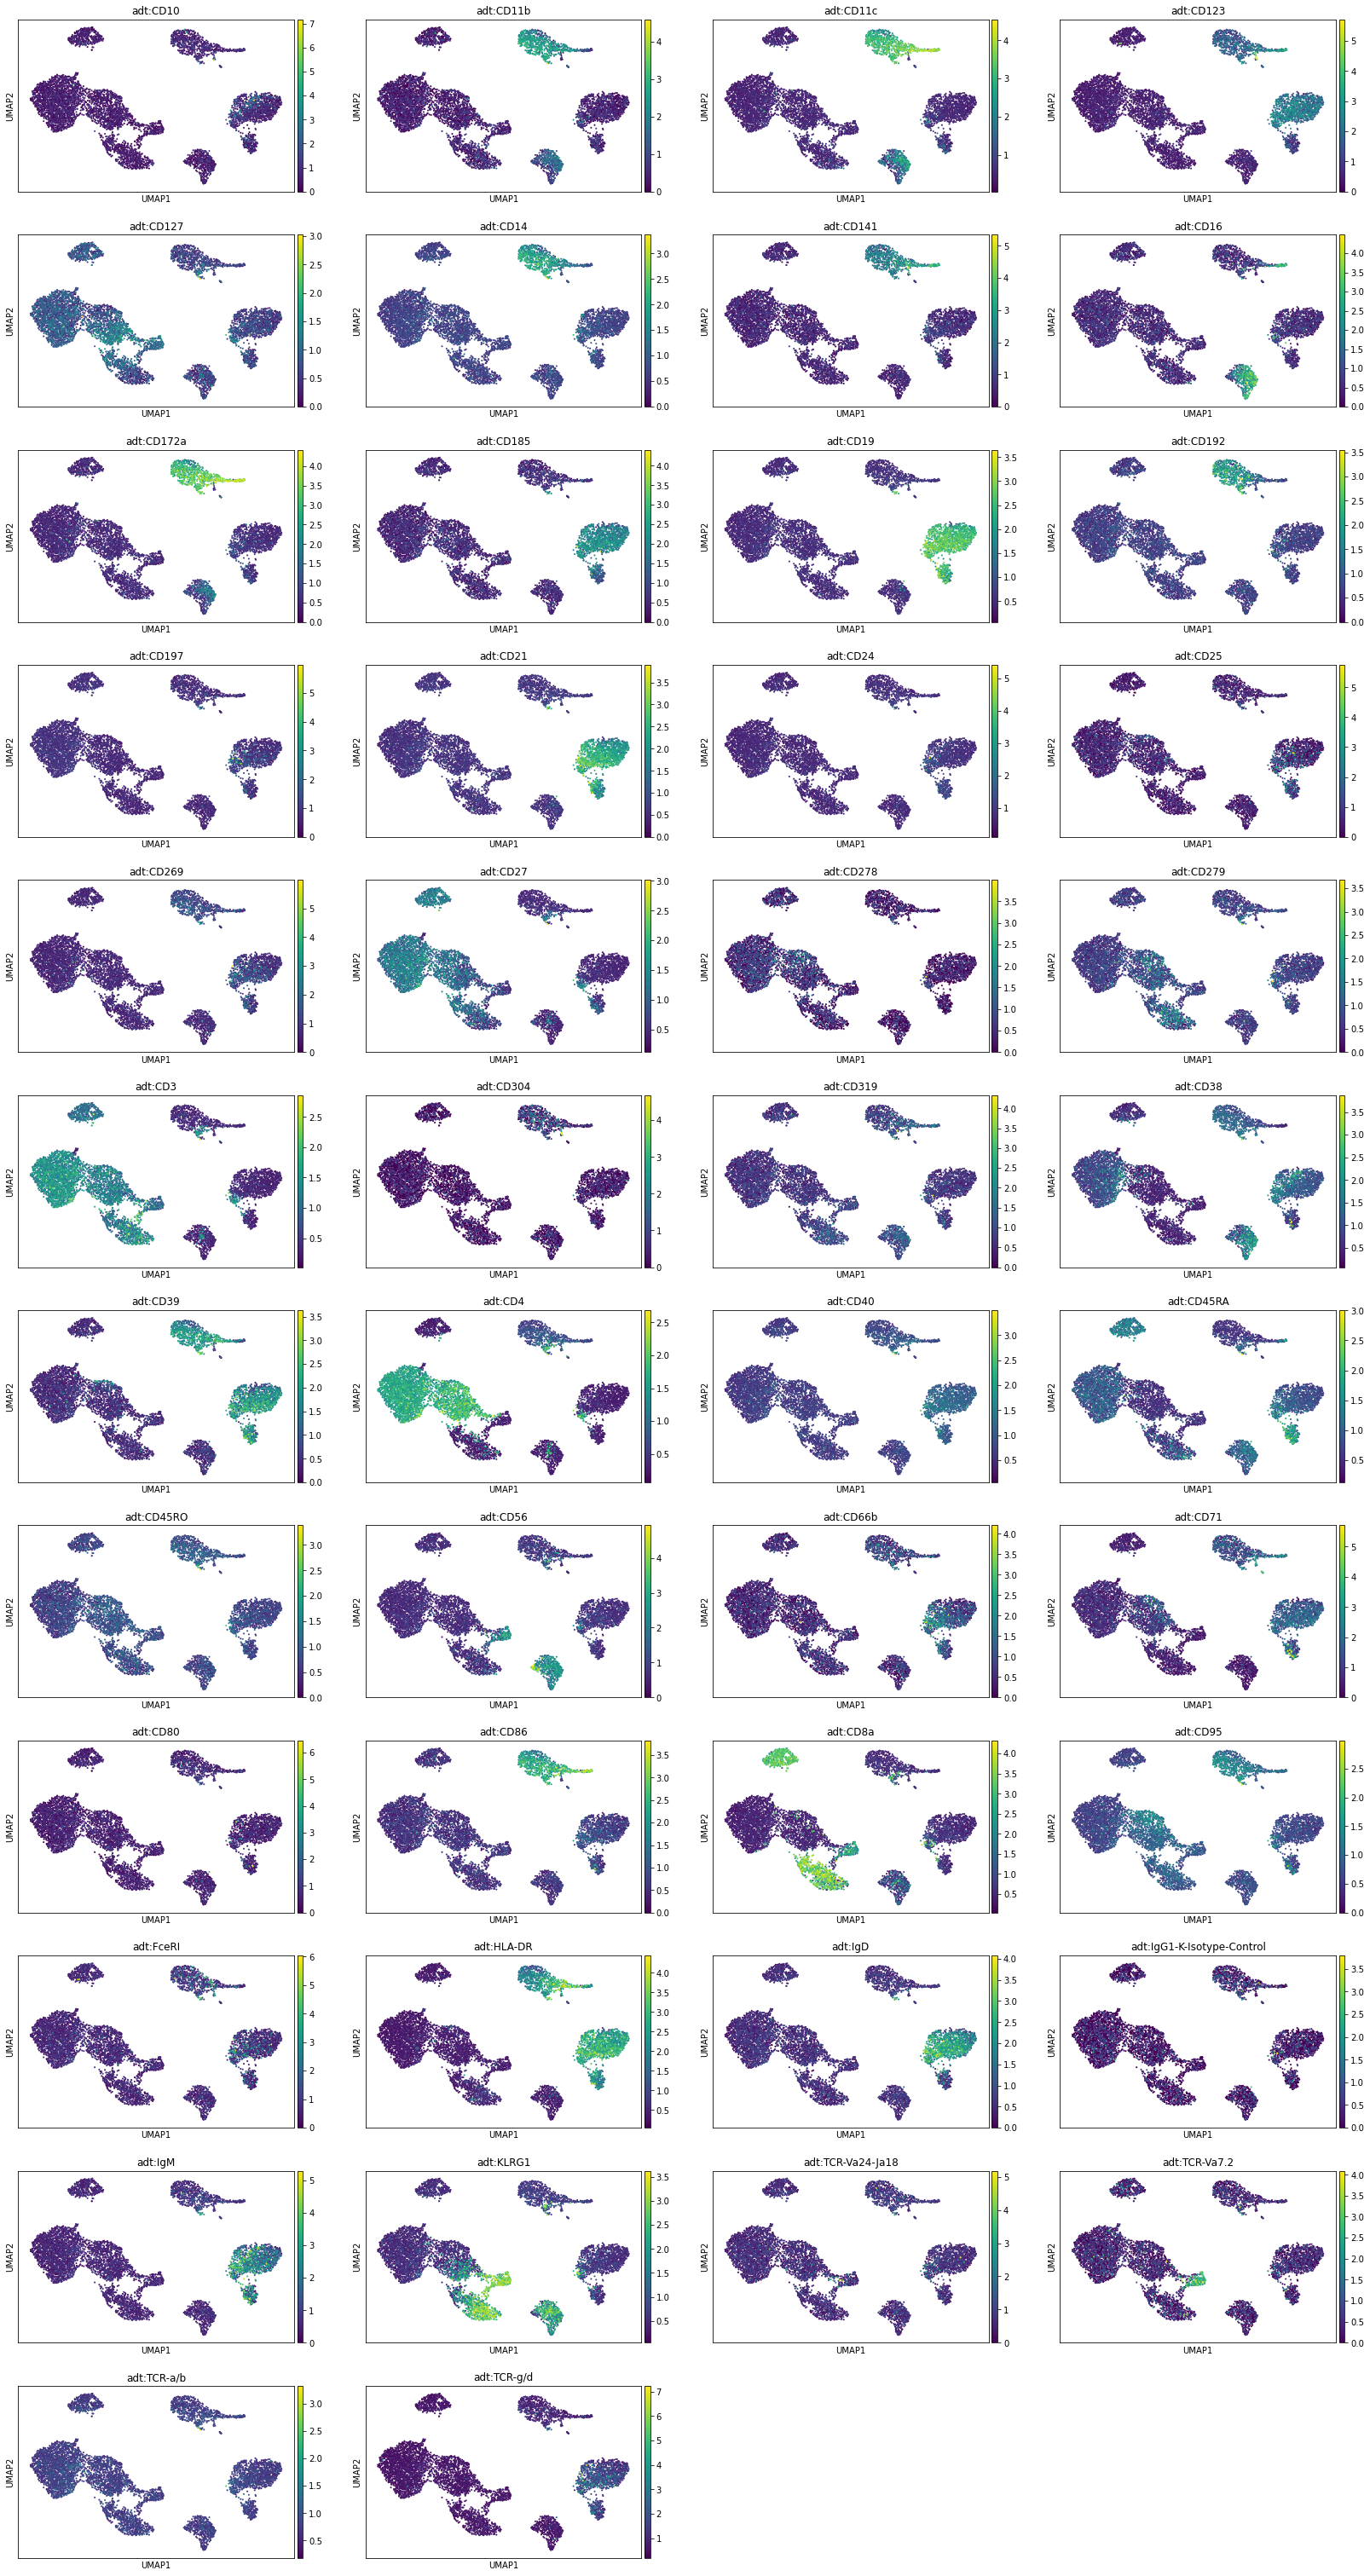

In [19]:
sc.pl.umap(
    joint_embedding,
    color=mdata["adt"].var_names,
)

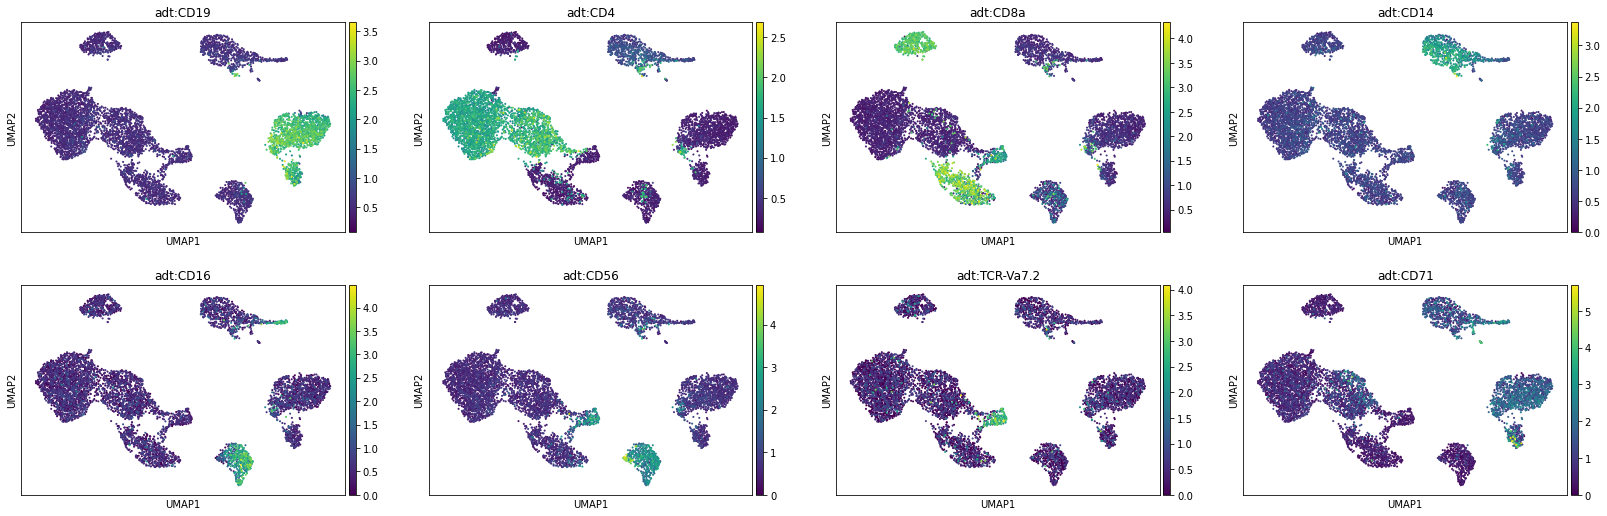

In [20]:
sc.pl.umap(
    joint_embedding,
    color=[
        "adt:CD19", # B cells
        "adt:CD4", # CD4 T cells
        "adt:CD8a", # CD8 T cells
        "adt:CD14", # Monocytes
        "adt:CD16", # Monocytes
        "adt:CD56", # NK cells
        "adt:TCR-Va7.2", # MAIT T cells
        "adt:CD71", # Erythroid cells
    ],
)

In [21]:
cluster_names = {
    1: "B cells",
    8: "B cells",
    0: "CD4 T cells",
    2: "CD4 T cells",
    4: "CD8 T cells",
    6: "CD8 T cells",
    3: "Monocytes",
    5: "NK cells",
    7: "MAIT T cells",
    9: "Erythroid cells",
}
joint_embedding.obs["leiden"] = [cluster_names[c] for c in joint_embedding.obs["leiden"].cat.codes]

In [22]:
sc.pl.umap(joint_embedding, color="leiden", alpha=.7, save="tea_leiden.pdf")

/users/csb/huizing/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'leiden' as categorical


In [23]:
sc.tl.dendrogram(joint_embedding, groupby="leiden_precise")
joint_embedding.obs["leiden_precise"] = joint_embedding.obs["leiden_precise"].cat.rename_categories(np.argsort(joint_embedding.uns["dendrogram_leiden_precise"]["categories_idx_ordered"]))
joint_embedding = joint_embedding[joint_embedding.obs["leiden_precise"].argsort()]

Trying to set attribute `.uns` of view, copying.


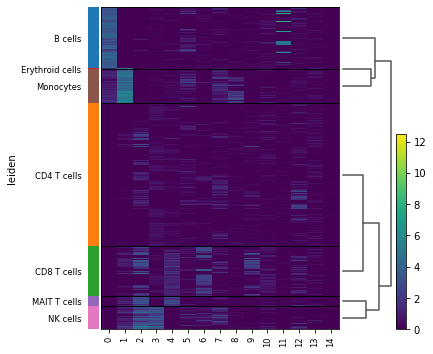

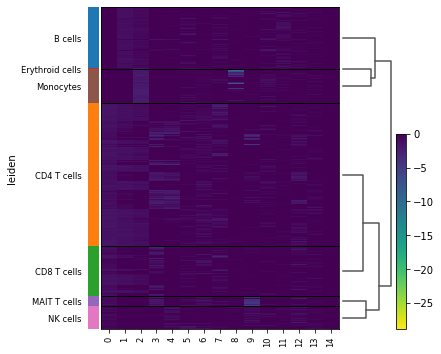

In [24]:
sc.tl.dendrogram(joint_embedding, groupby="leiden")
sc.pl.heatmap(
    joint_embedding,
    var_names=joint_embedding.var_names,
    groupby="leiden",
    dendrogram=True,
    vmin=0,
)
sc.pl.heatmap(
    joint_embedding,
    var_names=joint_embedding.var_names,
    groupby="leiden",
    dendrogram=True,
    vmax=0,
    cmap="viridis_r"
)


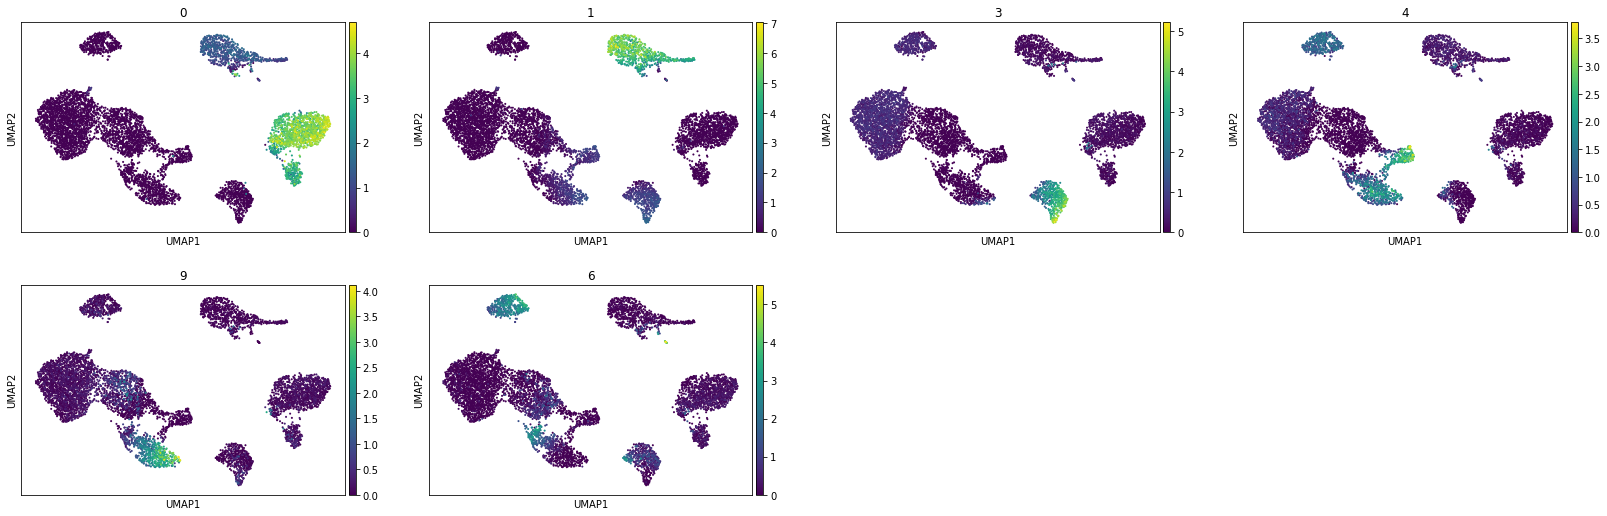

In [25]:
sc.pl.umap(
    joint_embedding,
    color=[
        "0", # B cells
        "1", # Monocytes
        "3", # NK cells
        "4", # MAIT T cells
        "9", # CD8 T cells
        "6", # Erythroid cells
    ],
    vmin=0
)

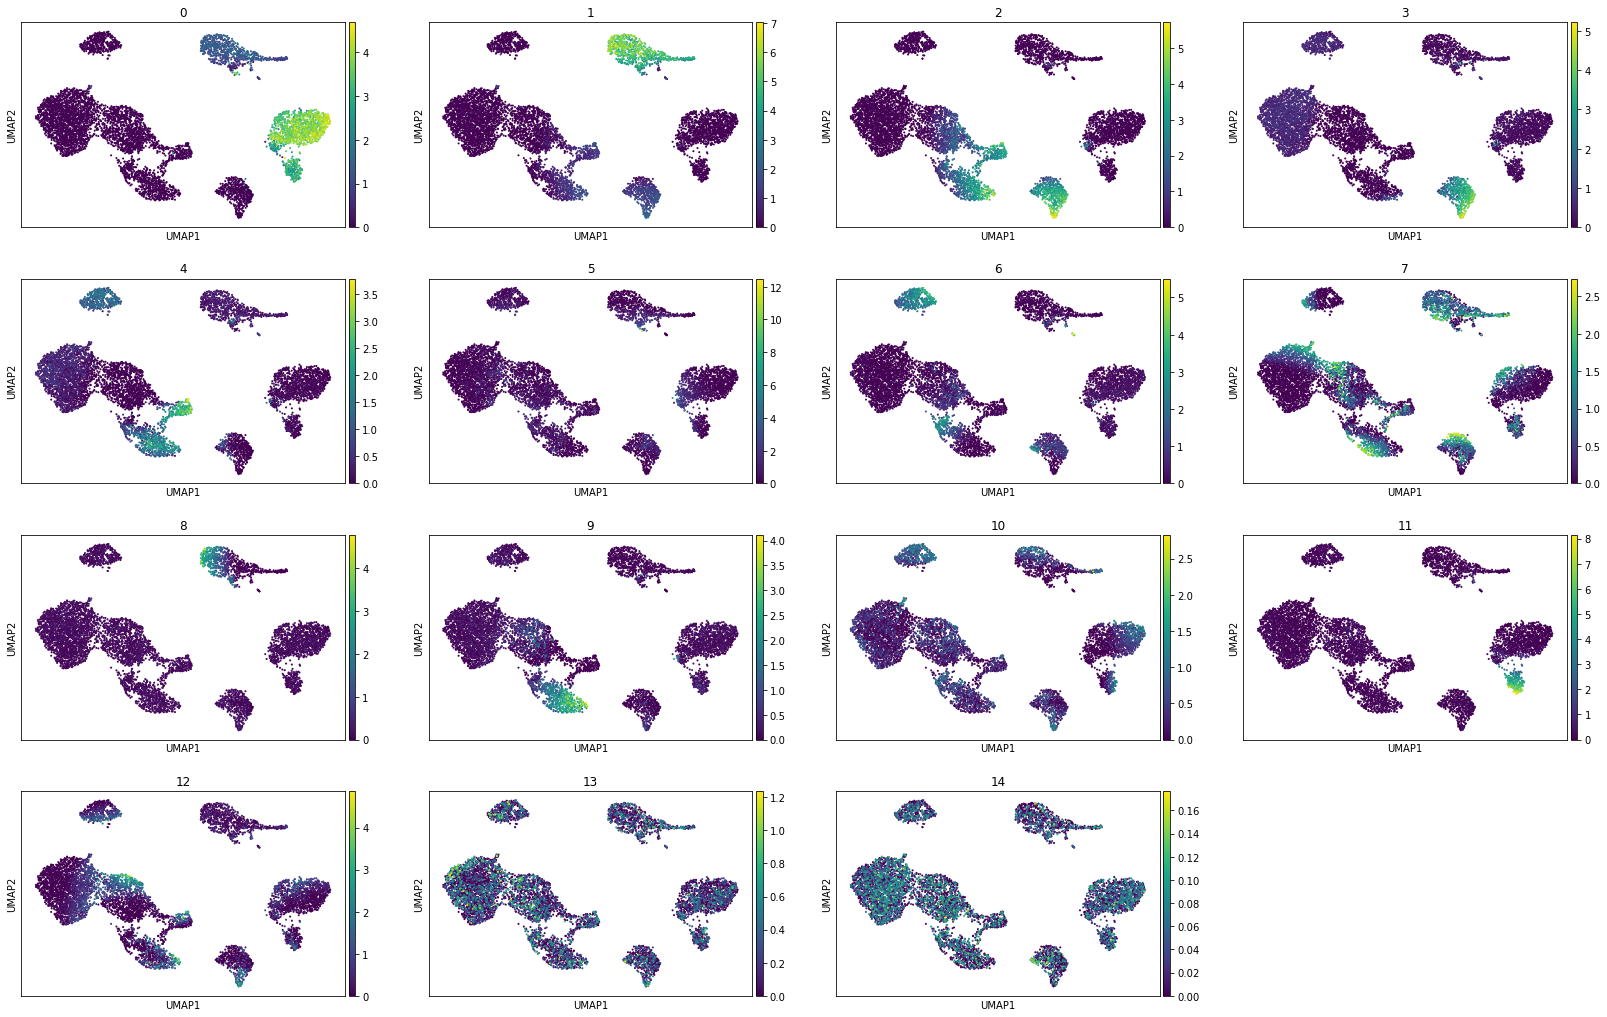

In [26]:
sc.pl.umap(
    joint_embedding,
    color=joint_embedding.var_names,
    vmin=0
)

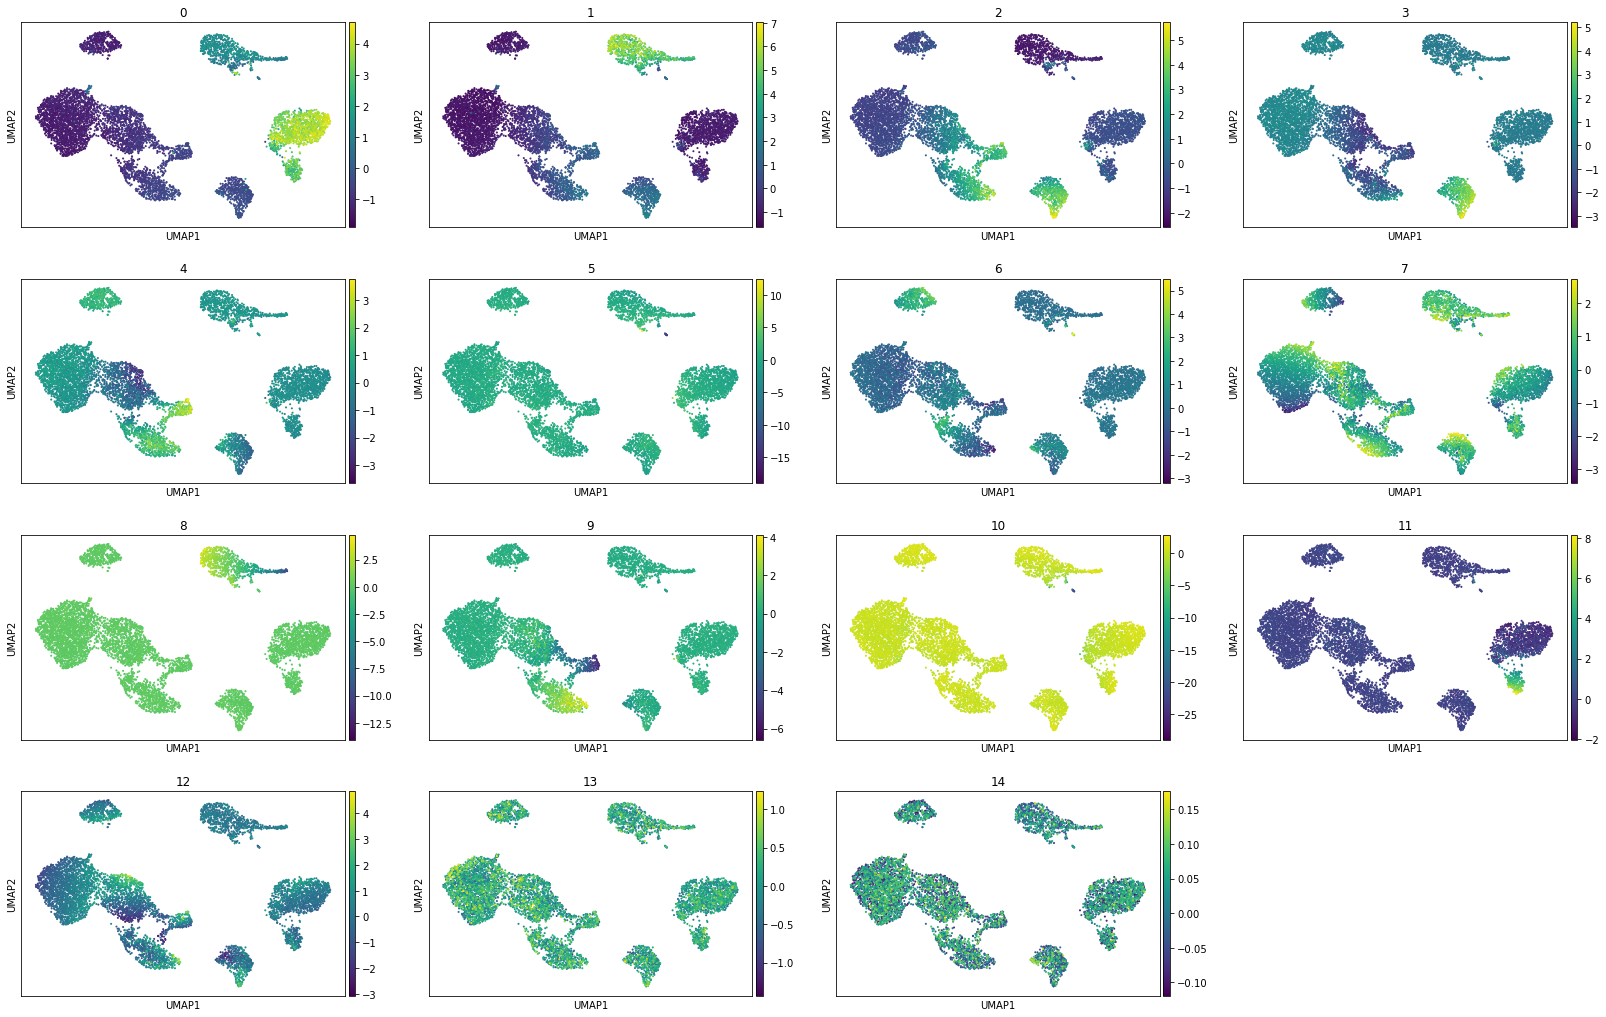

In [34]:
sc.pl.umap(
    joint_embedding,
    color=joint_embedding.var_names,
    # vmax=0
)

## Plot dictionary

In [28]:
H = {
    "H_rna": mofa_model.get_weights("rna"),
    "H_atac": mofa_model.get_weights("atac"),
    "H_adt": mofa_model.get_weights("adt")
}

In [29]:
def plot_proteins(dim):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5), constrained_layout=True)
    idx = H["H_adt"][:, dim].argsort()[::-1]
    labels = mdata["adt"].var_names.str.replace("adt:", "")[idx]
    ax.bar(labels, H["H_adt"][idx, dim])
    ax.set_title(f'Plotting dim {str(dim)}')
    ax.set_xticklabels(labels, rotation=90)
    plt.show()

def plot_genes(dim):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5), constrained_layout=True)
    idx = H["H_rna"][:, dim].argsort()[::-1]
    ax.plot(H["H_rna"][idx, dim])
    ax.set_title(f'Plotting dim {str(dim)}')
    plt.show()

def plot_peaks(dim):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5), constrained_layout=True)
    idx = H["H_atac"][:, dim].argsort()[::-1]
    ax.plot(H["H_atac"][idx, dim])
    ax.set_title(f'Plotting dim {str(dim)}')
    plt.show()

def top_proteins(dim):
    top_idx = H["H_adt"][:, dim].argsort()[::-1][:10]
    return mdata["adt"].var_names.str.replace("adt:", "")[top_idx].to_numpy(dtype=str)

def top_genes(dim):
    top_idx = H["H_rna"][:, dim].argsort()[::-1]
    return mdata["rna"].var_names.str.replace("rna:", "")[top_idx].to_numpy(dtype=str)

def top_peaks(dim):
    top_idx = H["H_atac"][:, dim].argsort()[::-1]
    return mdata["atac"].var_names.str.replace("atac:", "")[top_idx].to_numpy(dtype=str)

<ipython-input-29-15d012f491a1>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90)


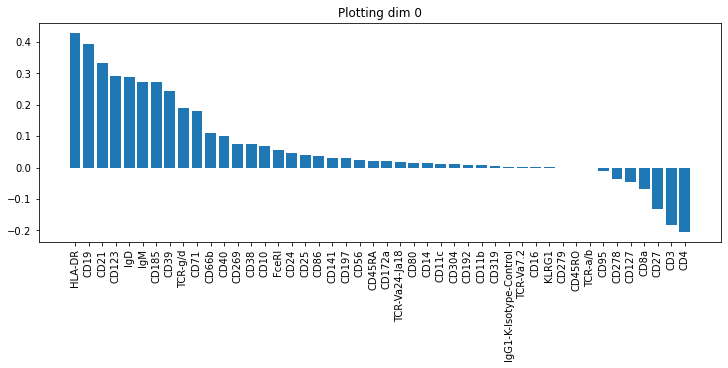

Top proteins: HLA-DR, CD19, CD21, CD123, IgD, IgM, CD185, CD39, TCR-g/d, CD71


<ipython-input-29-15d012f491a1>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90)


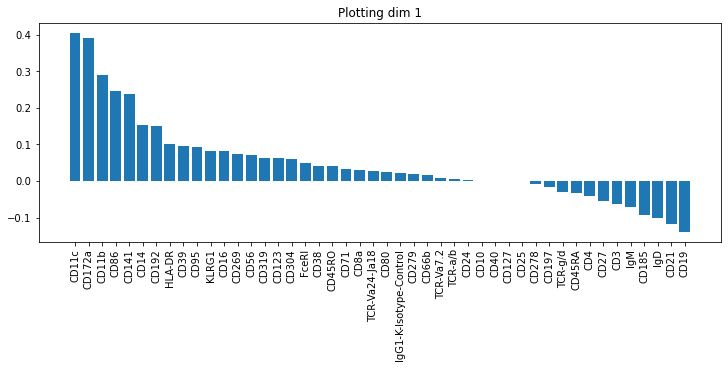

Top proteins: CD11c, CD172a, CD11b, CD86, CD141, CD14, CD192, HLA-DR, CD39, CD95


<ipython-input-29-15d012f491a1>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90)


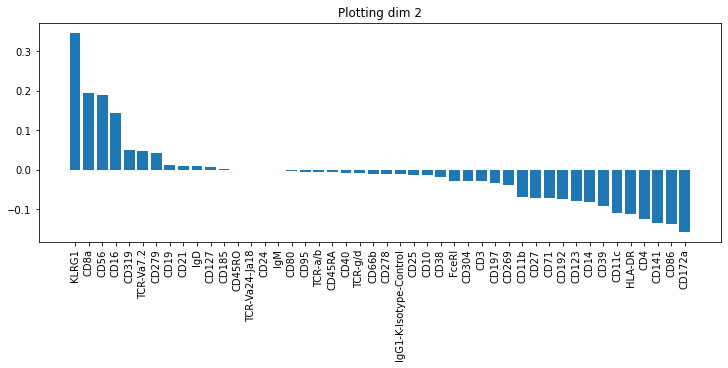

Top proteins: KLRG1, CD8a, CD56, CD16, CD319, TCR-Va7.2, CD279, CD19, CD21, IgD


<ipython-input-29-15d012f491a1>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90)


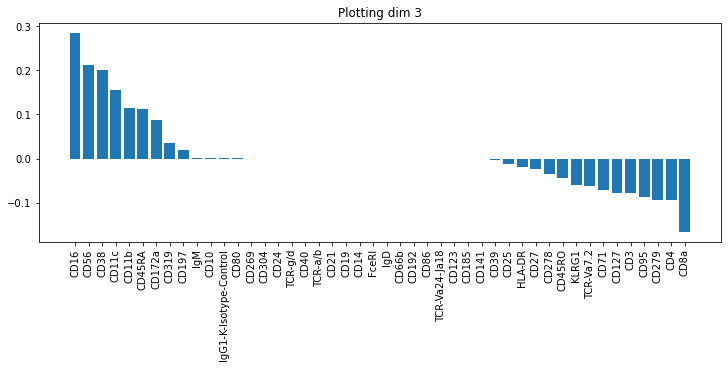

Top proteins: CD16, CD56, CD38, CD11c, CD11b, CD45RA, CD172a, CD319, CD197, IgM


<ipython-input-29-15d012f491a1>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90)


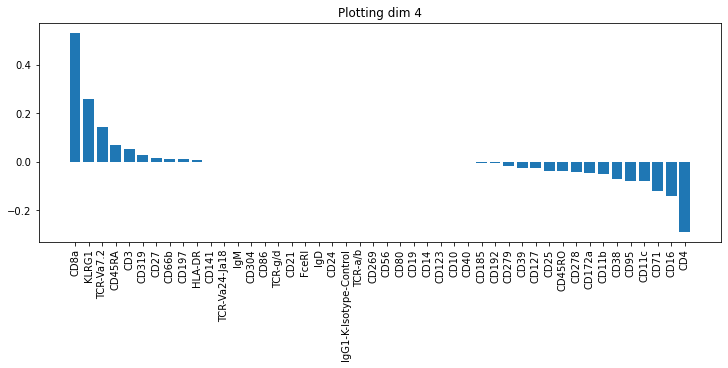

Top proteins: CD8a, KLRG1, TCR-Va7.2, CD45RA, CD3, CD319, CD27, CD66b, CD197, HLA-DR


<ipython-input-29-15d012f491a1>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90)


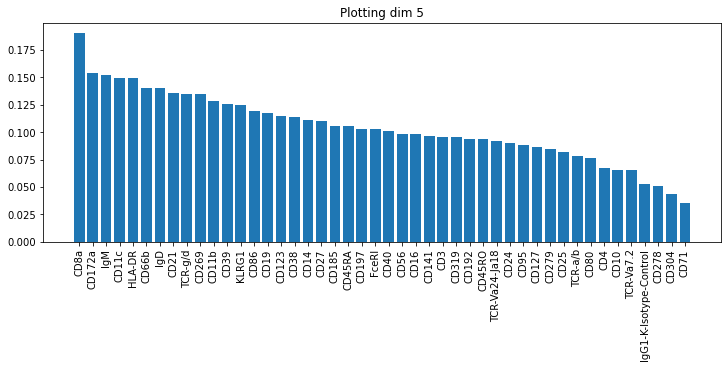

Top proteins: CD8a, CD172a, IgM, CD11c, HLA-DR, CD66b, IgD, CD21, TCR-g/d, CD269


<ipython-input-29-15d012f491a1>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90)


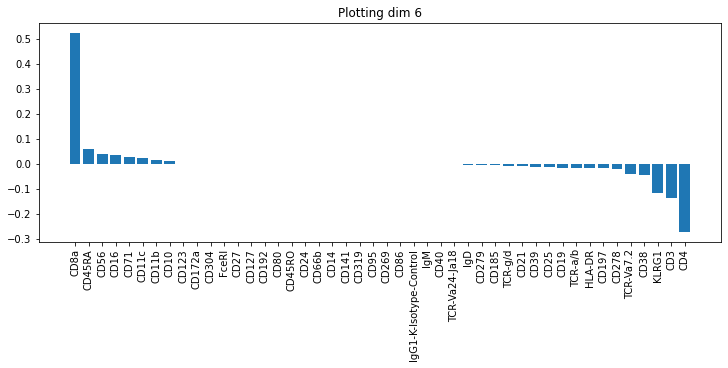

Top proteins: CD8a, CD45RA, CD56, CD16, CD71, CD11c, CD11b, CD10, CD123, CD172a


<ipython-input-29-15d012f491a1>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90)


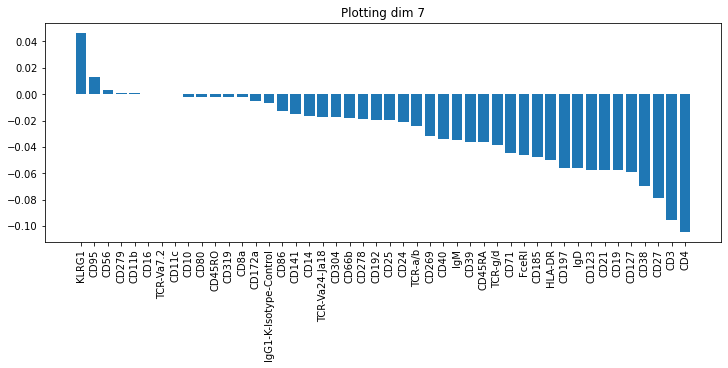

Top proteins: KLRG1, CD95, CD56, CD279, CD11b, CD16, TCR-Va7.2, CD11c, CD10, CD80


<ipython-input-29-15d012f491a1>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90)


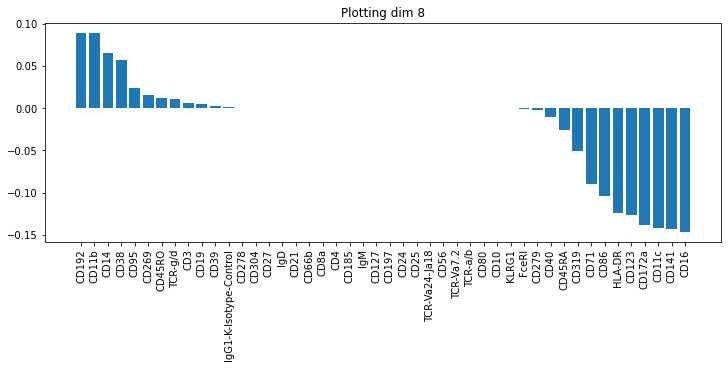

Top proteins: CD192, CD11b, CD14, CD38, CD95, CD269, CD45RO, TCR-g/d, CD3, CD19


<ipython-input-29-15d012f491a1>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90)


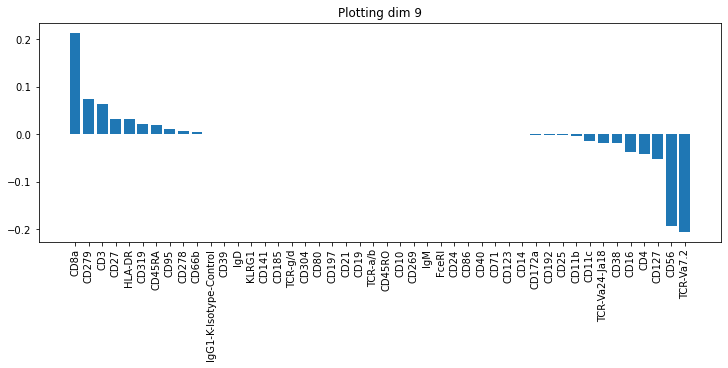

Top proteins: CD8a, CD279, CD3, CD27, HLA-DR, CD319, CD45RA, CD95, CD278, CD66b


<ipython-input-29-15d012f491a1>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90)


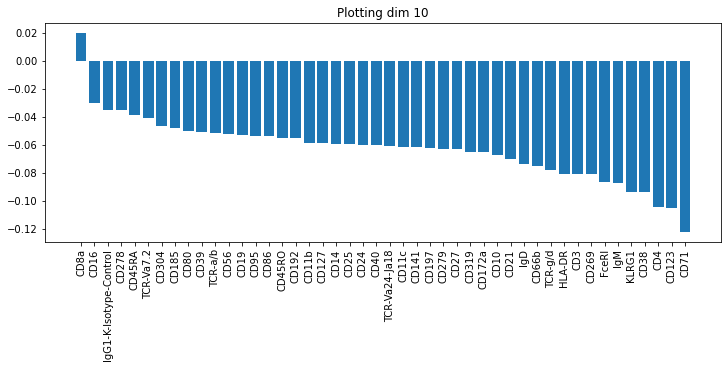

Top proteins: CD8a, CD16, IgG1-K-Isotype-Control, CD278, CD45RA, TCR-Va7.2, CD304, CD185, CD80, CD39


<ipython-input-29-15d012f491a1>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90)


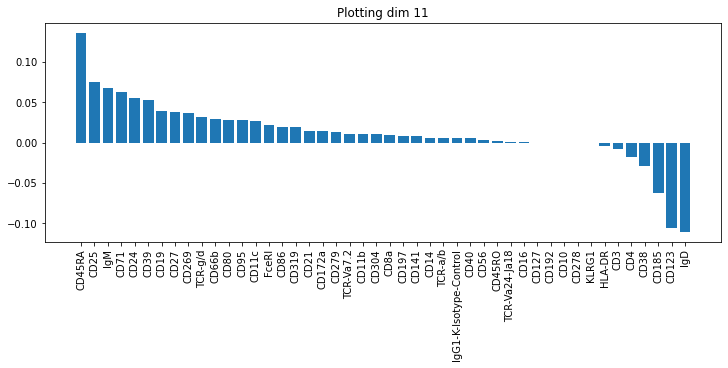

Top proteins: CD45RA, CD25, IgM, CD71, CD24, CD39, CD19, CD27, CD269, TCR-g/d


<ipython-input-29-15d012f491a1>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90)


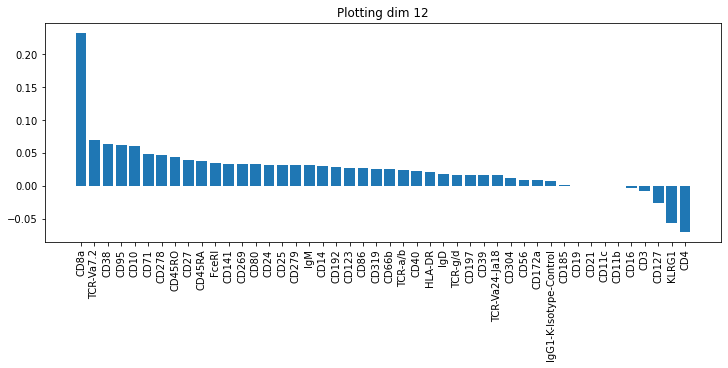

Top proteins: CD8a, TCR-Va7.2, CD38, CD95, CD10, CD71, CD278, CD45RO, CD27, CD45RA


<ipython-input-29-15d012f491a1>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90)


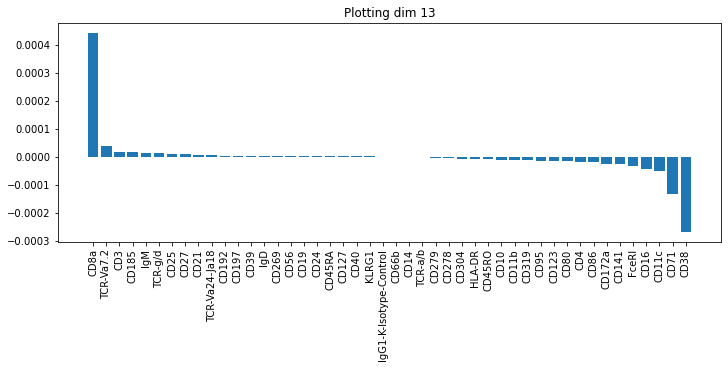

Top proteins: CD8a, TCR-Va7.2, CD3, CD185, IgM, TCR-g/d, CD25, CD27, CD21, TCR-Va24-Ja18


<ipython-input-29-15d012f491a1>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90)


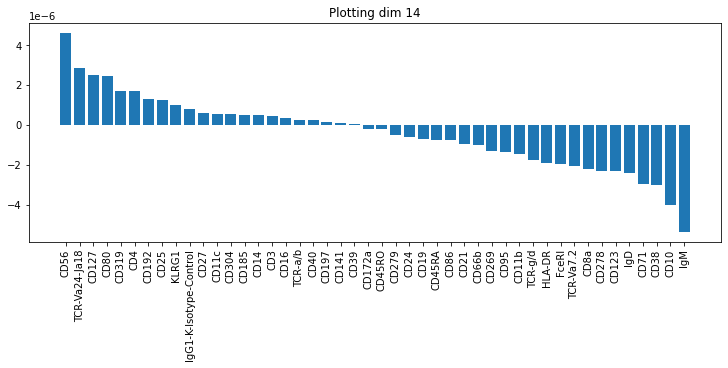

Top proteins: CD56, TCR-Va24-Ja18, CD127, CD80, CD319, CD4, CD192, CD25, KLRG1, IgG1-K-Isotype-Control


In [30]:
for dim in range(15):
    plot_proteins(dim)
    print("Top proteins:", ", ".join(top_proteins(dim)))

## Enrich

In [20]:
import gget
import pyperclip

In [33]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

In [32]:
import gprofiler
from gprofiler import GProfiler
gp = GProfiler(return_dataframe=True)
enr = gp.profile(
    organism="hsapiens",
    query={f"dim {dim}": list(top_genes(dim)[:200]) for dim in range(15)},
    sources=["GO:BP"],
)
enr["minlogp"] = -np.log10(enr["p_value"])
enr["occurences"] = enr["native"].map(enr["native"].value_counts())

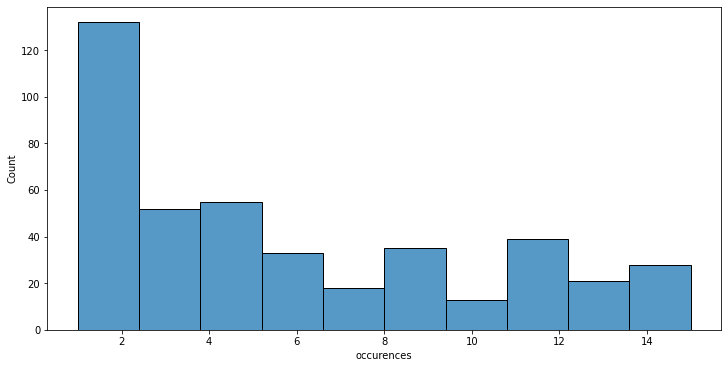

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5), constrained_layout=True)
sns.histplot(data=enr[enr["query"] == "dim 1"], x="occurences", ax=ax)
plt.show()

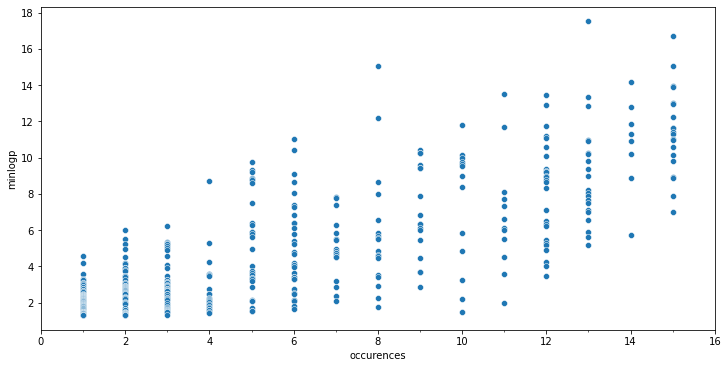

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5), constrained_layout=True)
sns.scatterplot(data=enr[enr["query"] == "dim 1"], y="minlogp", x="occurences", ax=ax)
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.set(xlim=(0, 16))
plt.show()

In [30]:
# pyperclip.copy("\n".join(top_genes(0)[:200])) # B cells
# pyperclip.copy("\n".join(top_genes(1)[:200])) # Monocytes
# pyperclip.copy("\n".join(top_genes(3)[:200])) # NK cells
# pyperclip.copy("\n".join(top_genes(4)[:200])) # MAIT T cells
# pyperclip.copy("\n".join(top_genes(9)[:200])) # CD8 T cells
pyperclip.copy("\n".join(top_genes(6)[:200])) # Erythroid cells

In [46]:
def enrich(dim: int, database: str):
    idx = H["H_rna"][:, dim].argsort()[::-1]
    enr = gget.enrichr(top_genes(dim), database)
    enr["min_log_adj_p_val"] = -np.log10(enr["adj_p_val"])
    sns.scatterplot(data=enr.head(), x='min_log_adj_p_val', y='path_name', s=150)
    plt.show()

Mon Aug 29 17:35:10 2022 INFO Performing Enichr analysis using database PanglaoDB_Augmented_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    
Mon Aug 29 17:35:10 2022 INFO Performing Enichr analysis using database PanglaoDB_Augmented_2021.


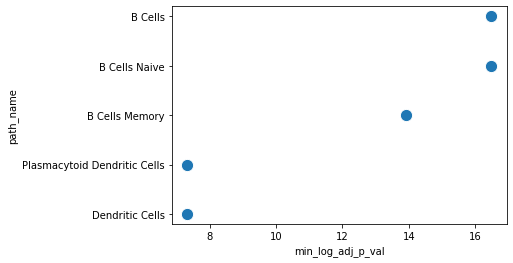

Mon Aug 29 17:35:11 2022 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    
Mon Aug 29 17:35:11 2022 INFO Performing Enichr analysis using database GO_Biological_Process_2021.


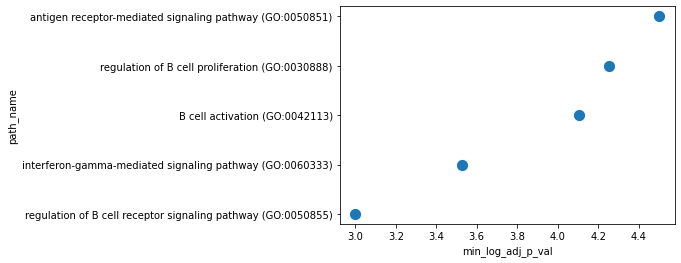

In [47]:
enrich(0, "celltypes")
enrich(0, "ontology")

Mon Aug 29 17:35:40 2022 INFO Performing Enichr analysis using database PanglaoDB_Augmented_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    
Mon Aug 29 17:35:40 2022 INFO Performing Enichr analysis using database PanglaoDB_Augmented_2021.


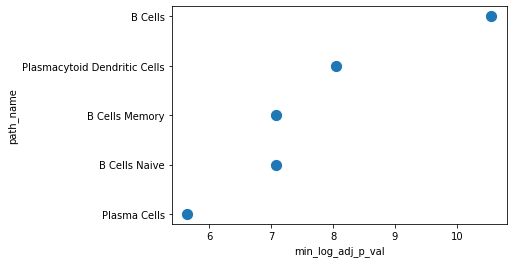

Mon Aug 29 17:35:41 2022 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    
Mon Aug 29 17:35:41 2022 INFO Performing Enichr analysis using database GO_Biological_Process_2021.


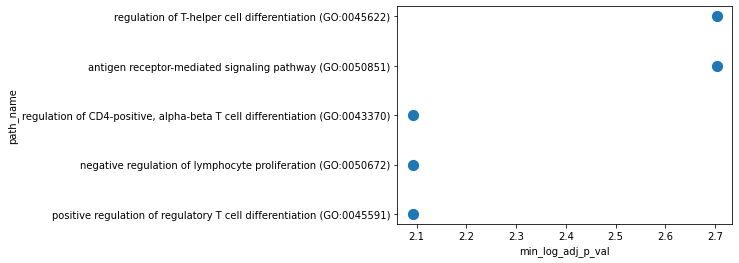

In [ ]:
enrich(11, "celltypes")
enrich(11, "ontology")

## Motifs

In [62]:
H_rescaled = H["H_atac"].copy()# / H["H_atac"].sum(1).reshape(-1, 1)
for dim in range(15):
    idx = H_rescaled[:, dim].argsort()[::-1][:1_000]
    mdata["atac"].var["top_in_dim_" + str(dim)] = False
    mdata["atac"].var.loc[
        mdata["atac"].var_names[idx].to_numpy(dtype=str),
        "top_in_dim_" + str(dim),
    ] = True


In [63]:
mdata["atac"].var.to_csv('/users/csb/huizing/Documents/PhD/Code/mowgli_reproducibility/enrich/top_var_mofa.csv')

In [107]:
# Run R

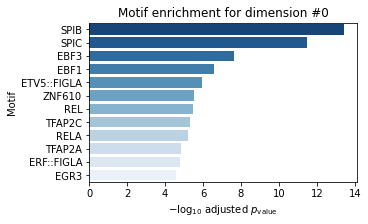

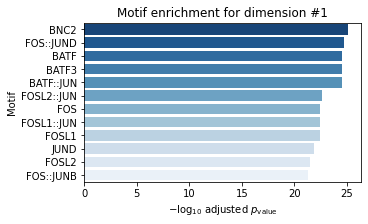

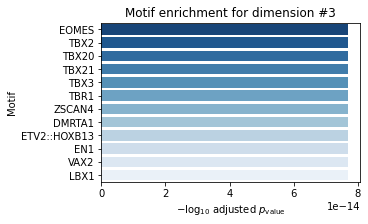

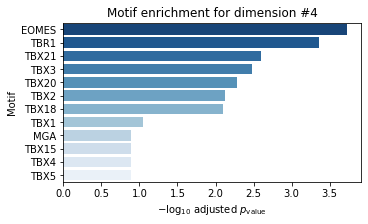

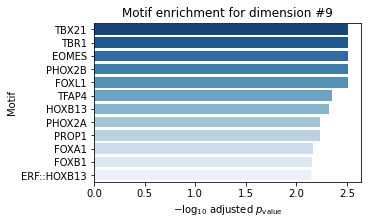

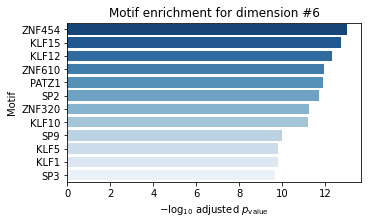

In [64]:
for dim in [0, 1, 3, 4, 9, 6]:

    fig, ax = plt.subplots(1, 1, figsize=(5, 3), constrained_layout=True)

    motifs = pd.read_csv(
        f"/users/csb/huizing/Documents/PhD/Code/mowgli_reproducibility/enrich/motifs_mofa/motifs_{dim}.csv",
        index_col=0,
    )
    motifs = motifs[motifs["motif"].str.startswith("MA")]
    motifs["minlogp.adjust"] = -np.log10(motifs["p.adjust"])
    sns.barplot(
        data=motifs[:12],
        x="minlogp.adjust",
        y="motif.name",
        ax=ax,
        palette="Blues_r",
    )
    ax.set_title(f"Motif enrichment for dimension #{dim}")
    ax.set_xlabel(r"$-\log_{10}~\mathrm{adjusted}~p_{\mathrm{value}}$")
    ax.set_ylabel("Motif")

    plt.show()
